# Quantum Approximate Optimization Algorithm (QAOA): MaxCut Problem

This notebook demonstrates the QAOA algorithm using Classiq. It covers the Max-Cut problem as an example of a combinatorial optimization problem, showcasing how QAOA can be applied to unconstrained combinatorial optimization tasks [[1](#QAOA)].

## Introduction

### The Max-Cut Problem

Given an undirected graph $G = (V, E)$, the goal is to partition the vertices into two sets **to maximize the number of edges between the sets**. In this context, an edge between is "cut" **if its endpoints belong to different sets**. The standard formulation is:

**Input:**  
- $G = (V, E)$: A graph with vertices $V$ and edges $E$.

**Output:**  
- A partition $S, \bar{S}$ that maximizes the cut value:
$$
f_{obj}(x)=\max_{S \subset V} \sum_{(i,j) \in E} \left(1 - \delta_{s_i, s_j}\right)
$$
where $s_i$ indicates the subset assignment for vertex $i$, and $\delta_{s_i, s_j}$ is the Kronecker delta function.

The Max-Cut problem is known to be $\mathsf{NP}$-complete.

**Note:** A weighted version exists, where each edge has a weight $w_{ij}$, and the goal is to maximize the weighted sum of cut edges.


### Set a Specific Problem Instance to Optimize

We choose a small toy Max-Cut instance using a **5-node graph**:
- **Vertices:** $V = \{0,1,2,3,4\}$
- **Edges:** $E = \{(0,1), (0,2), (1,2), (1,3), (2,4), (3,4)\}$

#### Optimal Max-Cut Solutions
Several partitions achieve the maximum cut value (cutting 5 out of 6 edges). For example:

**Option 1:**  
- **Set 1:** $\{0,2,3\}$
- **Set 2:** $\{1,4\}$

**Option 2:**  
- **Set 1:** $\{2,3\}$
- **Set 2:** $\{0,1,4\}$

Both options represent optimal solutions for this graph, showcasing the non-uniqueness of the optimal partition in a non-trivial Max-Cut instance.


## Algorithm Description

In this problem, we apply quantum transformations to optimize the Max-Cut objective. A quantum state $|x\rangle$ represents a candidate partition of the graph. The objective is defined as the negative, normalized number of cut edges—so that minimizing the cost is equivalent to maximizing the cut.

The QAOA algorithm comprises two key layers:

1. **Cost Layer:**  
   A phase rotation in the $Z$-direction is applied based on the cost function:
   $$
   |x\rangle \xrightarrow{U_{\text{o}}(\gamma)} e^{i\gamma f_{\text{obj}}(x)} |x\rangle,
   $$
   which encodes the cost associated with a given partition.

2. **Mixer Layer:**  
   An $X$-rotation is applied to all qubits:
   $$
   U_B(\beta) = e^{-i\beta H_B}, \quad \text{with } H_B = \sum_i X_i.
   $$
   This layer drives transitions between computational basis states based on the phases that were assigned by the previous layer.

By alternating these layers, the QAOA ansatz iteratively refines the quantum state toward a partition that minimizes the Hamiltonian (and thus maximizes the number of cut edges).


## Algorithm Implementation using Classiq

The implementation follows a modular design:

- **Cost Function:**  
  The function `maxcut_cost` computes the normalized negative number of cut edges for a given partition.

- **Cost Layer:**  
  The quantum function `maxcut_cost_layer` uses the `phase` statement to encode this cost into the quantum state, with the parameter $\gamma$ controlling the phase rotation.

- **Mixer Layer:**  
  The function `mixer_layer` applies uniform $RX$ rotations (with parameter $\beta$) to all qubits.

- **QAOA Ansatz:**  
  The overall circuit is constructed by first preparing a uniform superposition (via a Hadamard transform) and then alternating the cost and mixer layers for a specified number of layers.


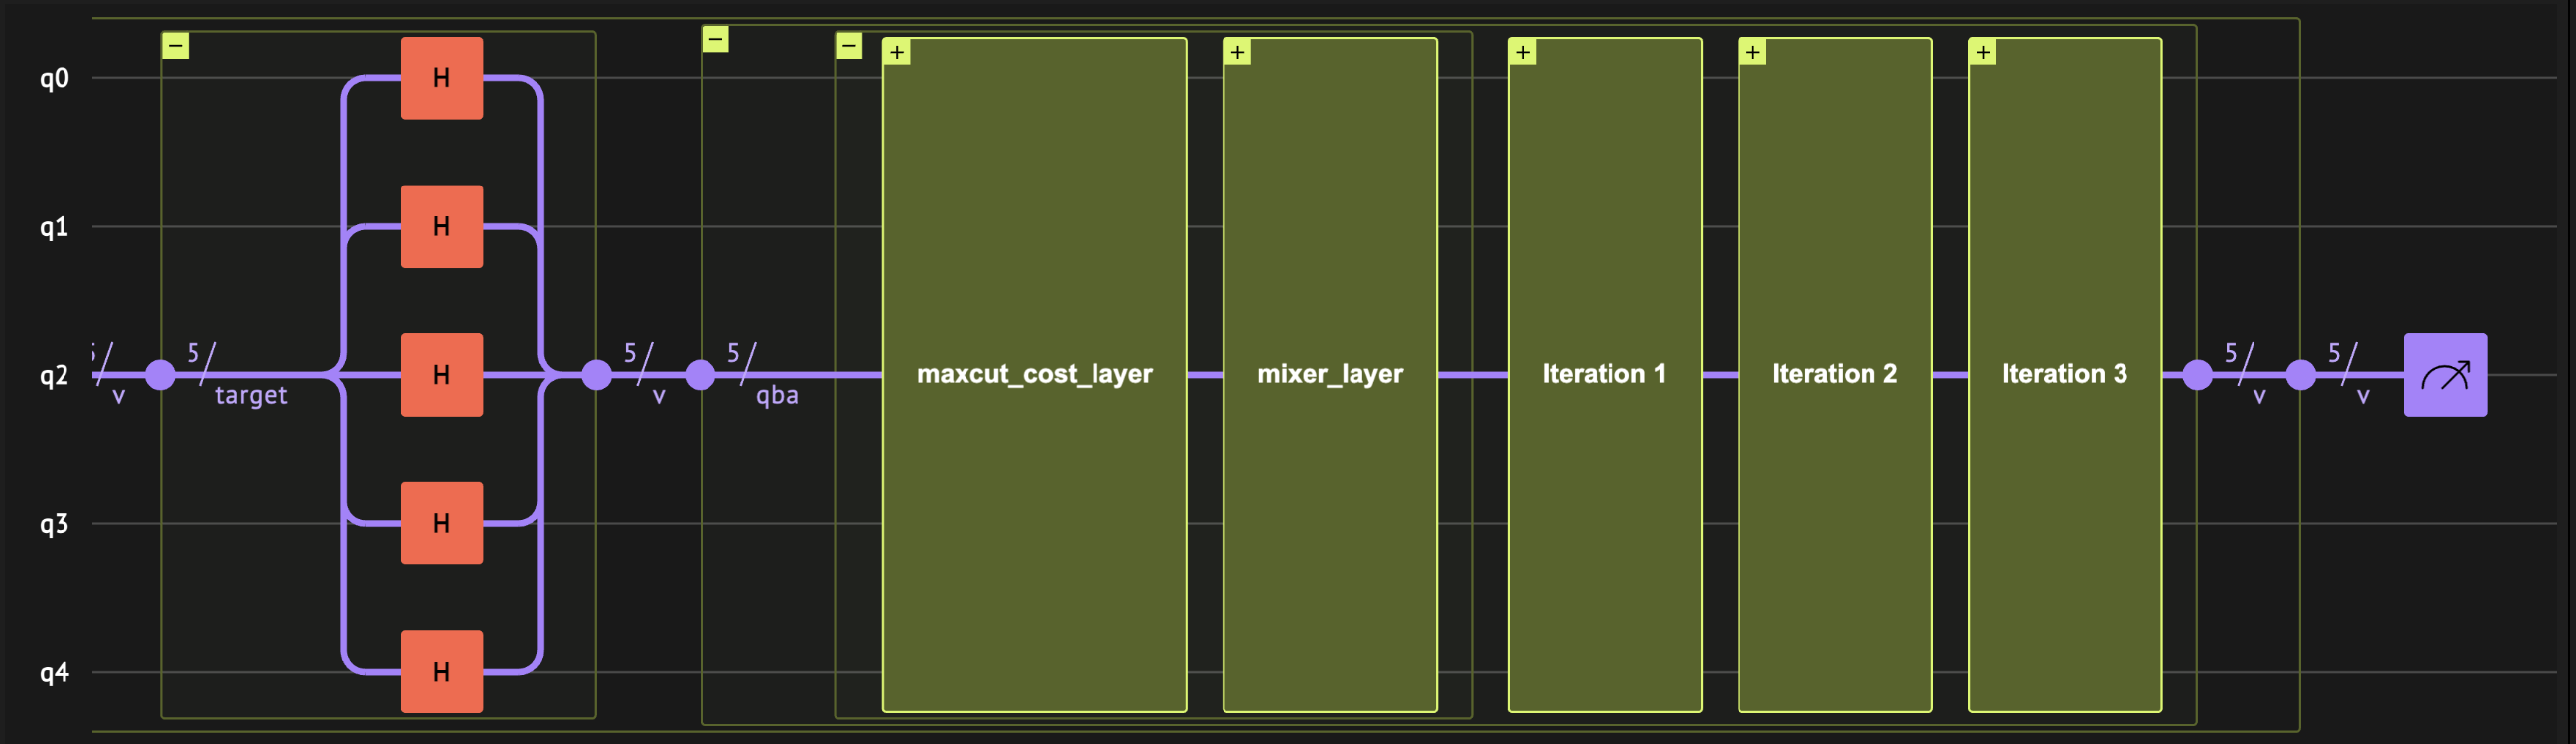

### Define the MaxCut problem

The implementation we are following is general, but to demonstrate it properly, you will use the specific problem described above. We begin by declaring the nodes and edges of the graph:

In [1]:
graph_edges = [(0, 1), (0, 2), (1, 2), (1, 3), (2, 4), (3, 4)]

Visualizing the above-defined graph:

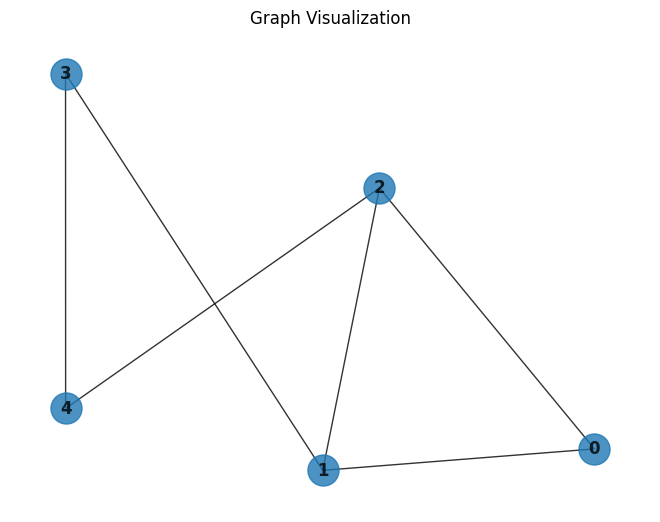

In [2]:
import matplotlib.pyplot as plt
import networkx as nx

# Create a graph instance
G = nx.Graph()
G.add_edges_from(graph_edges)

# Use a layout for better visualization
pos = nx.spring_layout(G)

# Draw the graph
nx.draw(G, pos, with_labels=True, alpha=0.8, node_size=500, font_weight="bold")
plt.title("Graph Visualization")
plt.show()

### Algorithms Building Blocks

#### The Cost Layer

The function `maxcut_cost` computes the normalized, negative cost of a partition represented by the quantum state `v`. Instead of using the conventional objective function:

$$
f_{obj}(x) = \sum_{(i,j) \in E} \left(1 - \delta_{s_i,s_j}\right),
$$

we define it as:

$$
\text{maxcut\_cost}(x) = -\frac{1}{|E|}\sum_{(i,j) \in E} \left(1 - \delta_{s_i,s_j}\right).
$$

This modification serves two purposes:

- **Normalization:** Dividing by the number of edges $|E|$ scales the cost to $\mathcal{O}(1)$, which helps prevent phase wrap-around in the QAOA circuit.
- **Negation for Minimization:** Reformulating the objective as a minimization problem is consistent with adiabatic approaches where the system transitions to its ground state.

*Note:* This function is reused both in the quantum phase encoding and in the classical optimizer.

Below is the implementation:

In [3]:
from classiq import *


def maxcut_cost(v: QArray[QBit] | list[int]):
    # Returns 1 if the edge is cut (i.e., vertices are in different sets), 0 otherwise.
    def edge_cut(node1, node2):
        return node1 * (1 - node2) + node2 * (1 - node1)

    # Compute the normalized, negative cost of the partition.
    return -sum(edge_cut(v[node1], v[node2]) for (node1, node2) in graph_edges) / len(
        graph_edges
    )

The following quantum function, `maxcut_cost_layer`, uses the `phase` operation to encode the computed cost into the phase of the quantum state. The parameter $\gamma$ controls the phase angle.

In [4]:
@qfunc
def maxcut_cost_layer(gamma: CReal, v: QArray[QBit]):
    phase(-maxcut_cost(v), gamma)

#### The Mixer Layer

The next main building block is the **mixer layer**. This layer drives transitions between computational basis states by applying RX rotations to all qubits. These transitions allow the quantum state to explore different candidate solutions based on the phases assigned by the cost layer.

Below, the `mixer_layer` is implemented as a quantum function that applies an RX rotation (parameterized by $\beta$) to each qubit in the array.

In [5]:
@qfunc
def mixer_layer(beta: CReal, qba: QArray[QBit]):
    apply_to_all(lambda q: RX(beta, q), qba)

#### The QAOA Ansatz

The overall QAOA ansatz alternates between two layers for a specified number of iterations:
- The **cost layer** encodes the problem’s objective into the quantum state.
- The **mixer layer** promotes transitions between different candidate solutions.

The ansatz operates on a uniform superposition state (prepared in the `main` function) by repeatedly applying these two layers.

In [6]:
@qfunc
def qaoa_ansatz(
    cost_layer: QCallable[CReal, QArray[QBit]],
    gammas: CArray[CReal],
    betas: CArray[CReal],
    qba: QArray[QBit],
):
    repeat(
        betas.len,
        lambda i: [
            cost_layer(gammas[i], qba),
            mixer_layer(betas[i], qba),
        ],
    )

## Assemble to the full QAOA algorithm

The quantum program first applies a `hadamard_transform` to prepare the qubits in a uniform superposition. After this initial state preparation, the circuit sequentially applies the cost and mixer layers, each with their own parameters that are updated by the classical optimization loop as we will show in the next section.

In [7]:
NUM_LAYERS = 4


@qfunc
def main(
    params: CArray[
        CReal, NUM_LAYERS * 2
    ],  # Execution parameters (first half: gammas, second half: betas), used later by the sample method
    v: Output[QArray[QBit, G.number_of_nodes()]],
):
    allocate(v)
    hadamard_transform(v)  # Prepare a uniform superposition
    qaoa_ansatz(
        maxcut_cost_layer,
        params[0:NUM_LAYERS],
        params[NUM_LAYERS : 2 * NUM_LAYERS],
        v,
    )

Having defined the `main` function, you can now create the model, synthesize it, and display the resulting quantum program. Note that the synthesized program is not yet executable because no parameter set has been specified. An `ExecutionSession` is defined to run the program with different parameter sets (stored in a `CArray[CReal, NUM_LAYERS * 2]`) during optimization, and ultimately to solve the problem using the optimized parameters.

In [8]:
from classiq.execution import *

NUM_SHOTS = 1000  # Per parameters set

qmod = create_model(
    main, execution_preferences=ExecutionPreferences(num_shots=NUM_SHOTS)
)
qprog = synthesize(qmod)

es = ExecutionSession(qprog)
show(qprog)

Opening: https://platform.classiq.io/circuit/2uu0WJYN11mNnjaBWbOsqrMHqGv?login=True&version=0.73.0
https://platform.classiq.io/circuit/2uu0WJYN11mNnjaBWbOsqrMHqGv?login=True&version=0.73.0


## Classical Optimization

We have constructed a modular, parameterized QAOA circuit for the Max-Cut problem. The circuit accepts a parameter array of size $NUM\_LAYERS \times 2$, with the first half corresponding to the cost layer parameters (gammas) and the second half to the mixer layer parameters (betas).

We execute the circuit using an `ExecutionSession`, which is configured to sample a fixed number of shots ($NUM\_SHOTS$) per evaluation. The function `ExecutionSession.estimate_cost` computes the cost for a given parameter set using the `maxcut_cost` function embedded in our cost layer.

Our classical optimization uses `scipy.optimize.minimize` with the COBYLA method. By minimizing our (negative) cost function, we are effectively maximizing the number of cut edges.

Below is the code that implements the classical optimization loop.

We define the objective function `objective_func` to evaluate the current parameters. This function takes a parameter vector, converts it to a list, and then calls `es.estimate_cost` with our cost function. The optimizer minimizes this function. Additionally, we initialize two lists—`cost_trace` and `params_history`—to record the cost and parameter values at each iteration for later analysis or debugging.

*Note:* `cost_func` is defined later as a lambda function that computes the cost using `maxcut_cost(state["v"])`.

In [9]:
cost_trace = []
params_history = []


def objective_func(params):
    cost_estimation = es.estimate_cost(cost_func, {"params": params.tolist()})
    cost_trace.append(cost_estimation)
    params_history.append(params.copy())
    return cost_estimation

The following code creates an execution session, initializes the parameters, runs the COBYLA optimizer to find the best parameters, and finally samples the circuit with the optimized parameters.

In [10]:
import numpy as np
import scipy
from tqdm import tqdm

NUM_SHOTS = 1000
MAX_ITERATIONS = 60

initial_params = np.concatenate(
    (np.linspace(0, 1, NUM_LAYERS), np.linspace(1, 0, NUM_LAYERS))
)

# Define the cost function used in the quantum circuit
cost_func = lambda state: maxcut_cost(state["v"])

with tqdm(total=MAX_ITERATIONS, desc="Optimization Progress", leave=True) as pbar:

    def progress_bar(xk: np.ndarray) -> None:
        pbar.update(1)

    optimization_results = scipy.optimize.minimize(
        fun=objective_func,
        x0=initial_params,
        method="COBYLA",
        options={"maxiter": MAX_ITERATIONS},
        callback=progress_bar,
    )

# Sample the circuit using the optimized parameters
res = es.sample({"params": optimization_results.x.tolist()})
es.close()

print(f"Optimized parameters: {optimization_results.x.tolist()}")

Optimization Progress:   0%|           | 0/60 [00:00<?, ?it/s]

Optimization Progress:   2%|   | 1/60 [00:02<02:04,  2.12s/it]

Optimization Progress:   3%|   | 2/60 [00:03<01:31,  1.59s/it]

Optimization Progress:   5%|▏  | 3/60 [00:04<01:13,  1.28s/it]

Optimization Progress:   7%|▏  | 4/60 [00:05<01:12,  1.30s/it]

Optimization Progress:   8%|▎  | 5/60 [00:06<01:09,  1.27s/it]

Optimization Progress:  10%|▎  | 6/60 [00:07<01:01,  1.15s/it]

Optimization Progress:  12%|▎  | 7/60 [00:08<01:02,  1.17s/it]

Optimization Progress:  13%|▍  | 8/60 [00:09<00:56,  1.09s/it]

Optimization Progress:  15%|▍  | 9/60 [00:11<00:58,  1.15s/it]

Optimization Progress:  17%|▎ | 10/60 [00:12<00:58,  1.17s/it]

Optimization Progress:  18%|▎ | 11/60 [00:13<00:58,  1.20s/it]

Optimization Progress:  20%|▍ | 12/60 [00:15<01:01,  1.28s/it]

Optimization Progress:  22%|▍ | 13/60 [00:15<00:54,  1.16s/it]

Optimization Progress:  23%|▍ | 14/60 [00:17<00:54,  1.18s/it]

Optimization Progress:  25%|▌ | 15/60 [00:18<00:54,  1.22s/it]

Optimization Progress:  27%|▌ | 16/60 [00:19<00:50,  1.14s/it]

Optimization Progress:  28%|▌ | 17/60 [00:20<00:50,  1.18s/it]

Optimization Progress:  30%|▌ | 18/60 [00:22<00:50,  1.21s/it]

Optimization Progress:  32%|▋ | 19/60 [00:22<00:45,  1.11s/it]

Optimization Progress:  33%|▋ | 20/60 [00:24<00:47,  1.18s/it]

Optimization Progress:  35%|▋ | 21/60 [00:25<00:46,  1.20s/it]

Optimization Progress:  37%|▋ | 22/60 [00:26<00:46,  1.21s/it]

Optimization Progress:  38%|▊ | 23/60 [00:27<00:41,  1.13s/it]

Optimization Progress:  40%|▊ | 24/60 [00:28<00:38,  1.06s/it]

Optimization Progress:  42%|▊ | 25/60 [00:29<00:39,  1.12s/it]

Optimization Progress:  43%|▊ | 26/60 [00:31<00:39,  1.17s/it]

Optimization Progress:  45%|▉ | 27/60 [00:31<00:35,  1.08s/it]

Optimization Progress:  47%|▉ | 28/60 [00:33<00:36,  1.13s/it]

Optimization Progress:  48%|▉ | 29/60 [00:34<00:33,  1.08s/it]

Optimization Progress:  50%|█ | 30/60 [00:35<00:33,  1.13s/it]

Optimization Progress:  52%|█ | 31/60 [00:36<00:30,  1.06s/it]

Optimization Progress:  53%|█ | 32/60 [00:37<00:31,  1.13s/it]

Optimization Progress:  55%|█ | 33/60 [00:38<00:31,  1.18s/it]

Optimization Progress:  57%|█▏| 34/60 [00:40<00:31,  1.20s/it]

Optimization Progress:  58%|█▏| 35/60 [00:41<00:28,  1.13s/it]

Optimization Progress:  60%|█▏| 36/60 [00:42<00:26,  1.09s/it]

Optimization Progress:  62%|█▏| 37/60 [00:43<00:23,  1.03s/it]

Optimization Progress:  63%|█▎| 38/60 [00:43<00:22,  1.02s/it]

Optimization Progress:  65%|█▎| 39/60 [00:45<00:22,  1.09s/it]

Optimization Progress:  67%|█▎| 40/60 [00:46<00:22,  1.13s/it]

Optimization Progress:  68%|█▎| 41/60 [00:47<00:20,  1.06s/it]

Optimization Progress:  70%|█▍| 42/60 [00:48<00:18,  1.03s/it]

Optimization Progress:  72%|█▍| 43/60 [00:49<00:18,  1.11s/it]

Optimization Progress:  73%|█▍| 44/60 [00:50<00:18,  1.17s/it]

Optimization Progress:  75%|█▌| 45/60 [00:51<00:16,  1.09s/it]

Optimization Progress:  77%|█▌| 46/60 [00:52<00:14,  1.05s/it]

Optimization Progress:  78%|█▌| 47/60 [00:53<00:13,  1.00s/it]

Optimization Progress:  80%|█▌| 48/60 [00:55<00:15,  1.31s/it]

Optimization Progress:  82%|█▋| 49/60 [00:56<00:14,  1.28s/it]

Optimization Progress:  83%|█▋| 50/60 [00:57<00:11,  1.17s/it]

Optimization Progress:  85%|█▋| 51/60 [00:59<00:10,  1.18s/it]

Optimization Progress:  87%|█▋| 52/60 [00:59<00:08,  1.09s/it]

Optimization Progress:  88%|█▊| 53/60 [01:00<00:07,  1.04s/it]

Optimization Progress:  90%|█▊| 54/60 [01:01<00:06,  1.03s/it]

Optimization Progress:  92%|█▊| 55/60 [01:03<00:05,  1.14s/it]

Optimization Progress:  93%|█▊| 56/60 [01:04<00:04,  1.19s/it]

Optimization Progress:  95%|█▉| 57/60 [01:05<00:03,  1.22s/it]

Optimization Progress:  97%|█▉| 58/60 [01:07<00:02,  1.23s/it]

Optimization Progress:  98%|█▉| 59/60 [01:08<00:01,  1.14s/it]

Optimization Progress: 100%|██| 60/60 [01:08<00:00,  1.07s/it]

Optimization Progress: 61it [01:08,  1.13s/it]                

Optimized parameters: [1.5221453321333955, -0.4206599377076905, 1.0317363980183625, 2.1651529091277064, 1.141070217515745, 1.7172936464359323, -0.23293124237827714, -0.5178825801570339]


Plotting the convergence graph: 

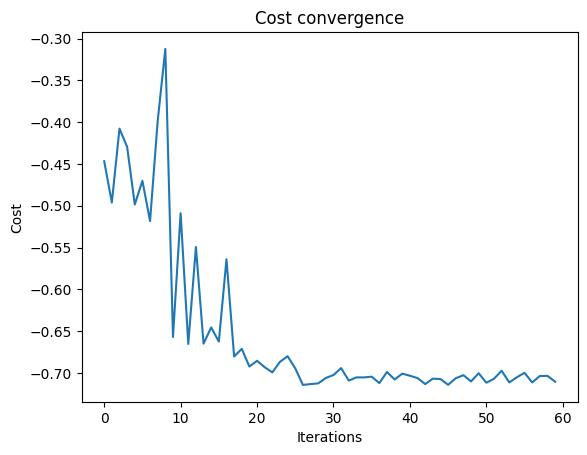

In [11]:
plt.plot(cost_trace)
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.title("Cost convergence")
plt.show()

## Displaying and Discussing the Results

After optimization, we print the optimized parameters and display the measurement outcomes. Each outcome is a bitstring representing a candidate partition, with its probability (the fraction of shots) and its cost (computed by `maxcut_cost`). For example, a cost of $-0.833$ indicates that 5 out of 6 edges are cut, which is optimal for this instance ($5/6 \approx 0.833$).

Below is the code that prints the resulting solutions according to the probability:

In [12]:
print(f"Optimized parameters: {optimization_results.x.tolist()}")
sorted_counts = sorted(res.parsed_counts, key=lambda pc: maxcut_cost(pc.state["v"]))
for sampled in sorted_counts:
    solution = sampled.state["v"]
    probability = sampled.shots / NUM_SHOTS
    cost_value = maxcut_cost(sampled.state["v"])
    print(f"solution={solution} probability={probability:.3f} cost={cost_value:.3f}")

Optimized parameters: [1.5221453321333955, -0.4206599377076905, 1.0317363980183625, 2.1651529091277064, 1.141070217515745, 1.7172936464359323, -0.23293124237827714, -0.5178825801570339]
solution=[1, 1, 0, 0, 1] probability=0.137 cost=-0.833
solution=[0, 1, 0, 0, 1] probability=0.131 cost=-0.833
solution=[0, 0, 1, 1, 0] probability=0.119 cost=-0.833
solution=[1, 0, 1, 1, 0] probability=0.112 cost=-0.833
solution=[0, 1, 1, 0, 0] probability=0.096 cost=-0.667
solution=[1, 0, 0, 1, 1] probability=0.061 cost=-0.667
solution=[1, 0, 0, 1, 0] probability=0.044 cost=-0.667
solution=[0, 1, 1, 1, 0] probability=0.039 cost=-0.667
solution=[1, 0, 0, 0, 1] probability=0.039 cost=-0.667
solution=[0, 1, 1, 0, 1] probability=0.038 cost=-0.667
solution=[0, 1, 0, 1, 0] probability=0.027 cost=-0.500
solution=[1, 1, 0, 1, 0] probability=0.026 cost=-0.500
solution=[0, 0, 1, 0, 1] probability=0.023 cost=-0.500
solution=[1, 0, 1, 0, 0] probability=0.013 cost=-0.500
solution=[1, 1, 0, 0, 0] probability=0.012 c

Plotting the solutions with the best cost values:

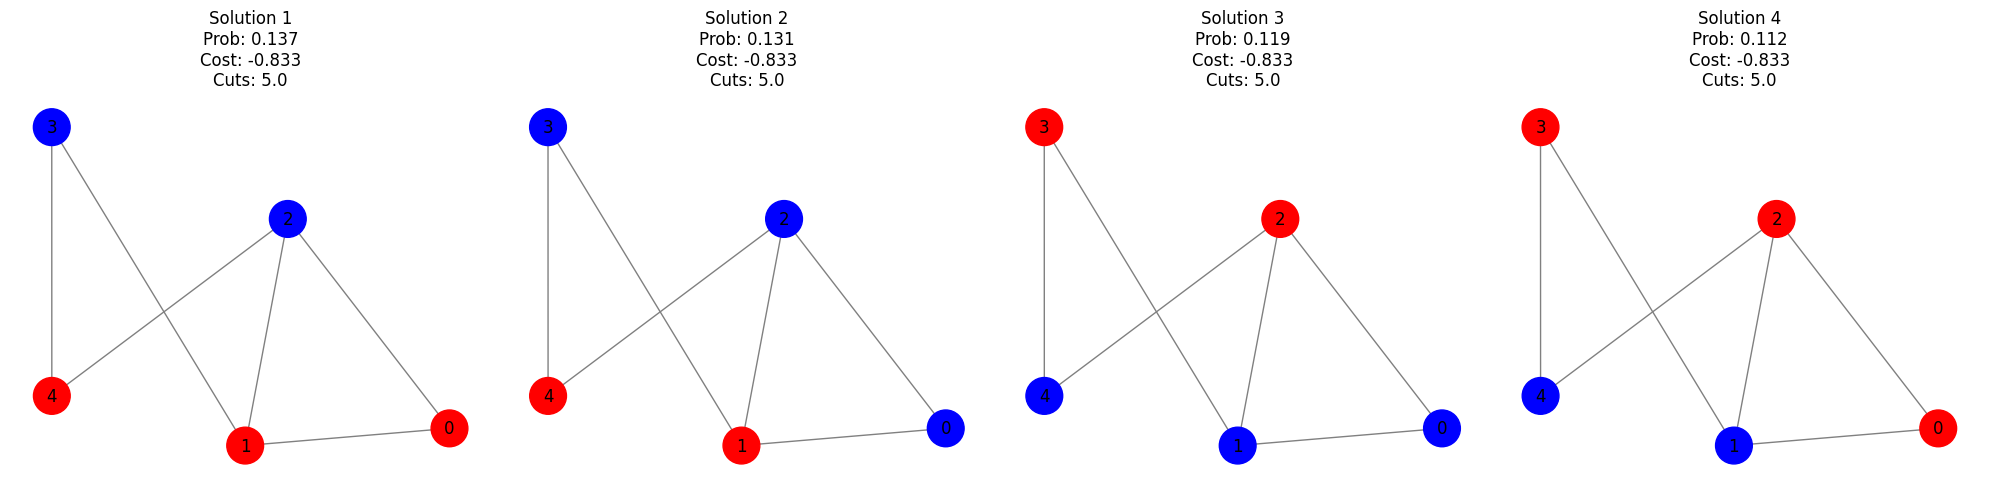

In [13]:
# Determine the best (minimum) cost among all sampled outcomes
best_cost = min(maxcut_cost(pc.state["v"]) for pc in res.parsed_counts)
tolerance = 1e-3

# Filter outcomes with cost within tolerance of best_cost
best_outcomes = [
    pc
    for pc in res.parsed_counts
    if abs(maxcut_cost(pc.state["v"]) - best_cost) < tolerance
]

# Sort outcomes by descending probability
best_outcomes = sorted(best_outcomes, key=lambda pc: pc.shots / NUM_SHOTS, reverse=True)

# Plot the optimal solutions
num_plots = len(best_outcomes)
fig, axes = plt.subplots(1, num_plots, figsize=(5 * num_plots, 5))
if num_plots == 1:
    axes = [axes]

for i, pc in enumerate(best_outcomes):
    solution = pc.state["v"]
    probability = pc.shots / NUM_SHOTS
    cost_value = maxcut_cost(pc.state["v"])
    num_cuts = abs(cost_value * G.size())  # number of cut edges

    node_colors = ["red" if bit == 1 else "blue" for bit in solution]
    nx.draw(
        G,
        pos,
        with_labels=True,
        node_color=node_colors,
        edge_color="gray",
        ax=axes[i],
        node_size=700,
    )
    axes[i].set_title(
        f"Solution {i+1}\nProb: {probability:.3f}\nCost: {cost_value:.3f}\nCuts: {num_cuts}"
    )

plt.tight_layout()
plt.show()

## References

<a id='QAOA'>[1]</a>: [Farhi, Edward, Jeffrey Goldstone, and Sam Gutmann. "A quantum approximate optimization algorithm." arXiv preprint arXiv:1411.4028 (2014).](https://arxiv.org/abs/1411.4028)

<a id='knapsack'>[2]</a>: [Maximum Cut Problem (Wikipedia)](https://en.wikipedia.org/wiki/Maximum_cut)